# Introduction
This project seeks to address the challenge of imitating the style of a particular artist when creating new images or altering existing images. This challenge will be attempted using a generative adversarial network (GAN). GANs consist of a generator model and discriminator model. The generator creates images and the discriminator compares them with real images to train the generator. 

Claude Monet was an important figure in the Impressionist movement. He frequently depicted scenes from Paris and the Normandy coast, particularly landscapes. His style has been described as striving to capture the very act of perceiving nature. Inspired by Japanese woodprints, he emphasized the two-dimensional surfaces of forms and eliminated linear perspective.[3]

The goal of this project is to transform photographs or generate images that imitate this unique style.

# Data
The data for this project was obtained from the Kaggle competition page [2]. The dataset consists of 300 Monet paintings in either JPEG or TFRecord format and 7038 photos in either JPEG or TFRecord format. 

Both the photos and paintings are height 256 pixels, width 256 pixels, and depth 3 for RGB. 

The output required for submission to the Kaggle competition is 7,000-10,000 images in the style of Monet. Converting the 7038 photos in the photo dataset to Monet's style would fit the problem rubric.

# Exploratory Data Analysis
First I will show a few Monet paintings to get a better idea of the style I am trying to reproduce with my model. Next I will explore the dataset with other visualizations to learn more about pixel values and other statistics to guide my GAN architecture.

In [19]:
# Important libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# EDA and data preprocessing
from PIL import Image
from random import choice
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Model Building
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras.layers import RandomRotation, RandomZoom, RandomTranslation, RandomFlip, RandomBrightness, GaussianNoise, Input, Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Painting shape: (256, 256, 3)


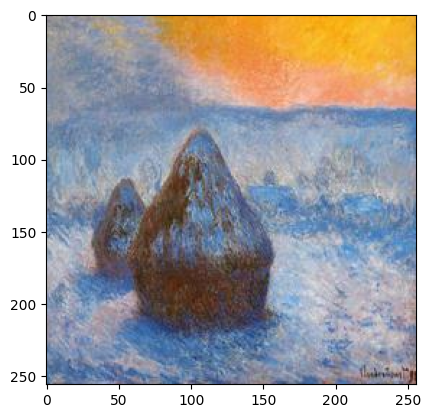

In [3]:
painting_paths = ['\\'.join(['monet_jpg', f]) for f in os.listdir('monet_jpg')]
example_painting_path = choice(painting_paths)
example_painting = Image.open(example_painting_path)
example_painting_array = np.array(example_painting)

print(f'Painting shape: {example_painting_array.shape}')
plt.imshow(example_painting)
plt.show()

In [4]:
# Load the images into ndarray
paintings = np.empty((300, 256, 256, 3))
for i, path in enumerate(painting_paths):
    painting = Image.open(path)
    paintings[i] = np.array(painting)

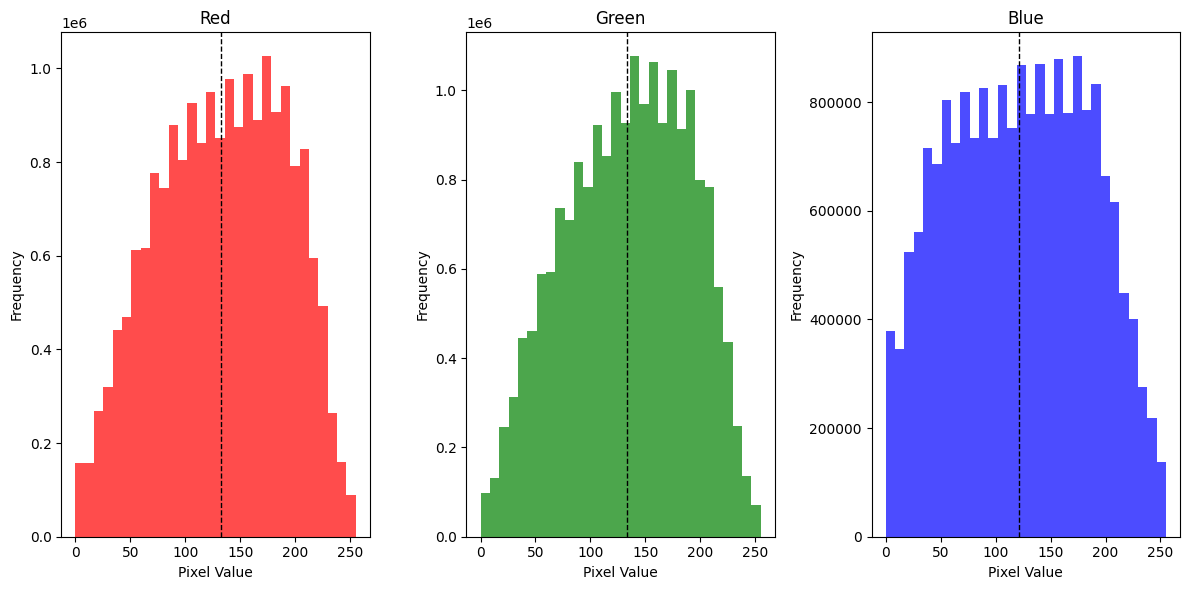

Red mean pixel value: 132.96300455729167
Green mean pixel value: 133.72787953694674
Blue mean pixel value: 121.57267918904626


In [5]:
# Calculate the mean across the first dimension (observations)
mean_values = np.mean(paintings, axis=0)  # Shape will be (96, 96, 3)

# Now, calculate the mean across the spatial dimensions (height and width) for each channel (rgb)
mean_channel_values = np.mean(mean_values, axis=(0, 1))  # Shape will be (3,)

# Create histograms for each channel
colors = ['r', 'g', 'b']  # Assuming channels are in RGB order
channel_labels = ['Red', 'Green', 'Blue']

plt.figure(figsize=(12, 6))

for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.hist(paintings[..., i].flatten(), bins=30, color=colors[i], alpha=0.7)
    plt.axvline(mean_channel_values[i], color='k', linestyle='dashed', linewidth=1)
    plt.title(channel_labels[i])
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

for color, mean in zip(channel_labels, mean_channel_values):
    print(f'{color} mean pixel value: {mean}')

The pixel values appear to be somewhat normally distributed. Green has the highest average pixel value which may be due to Monet's preference for painting landscapes.

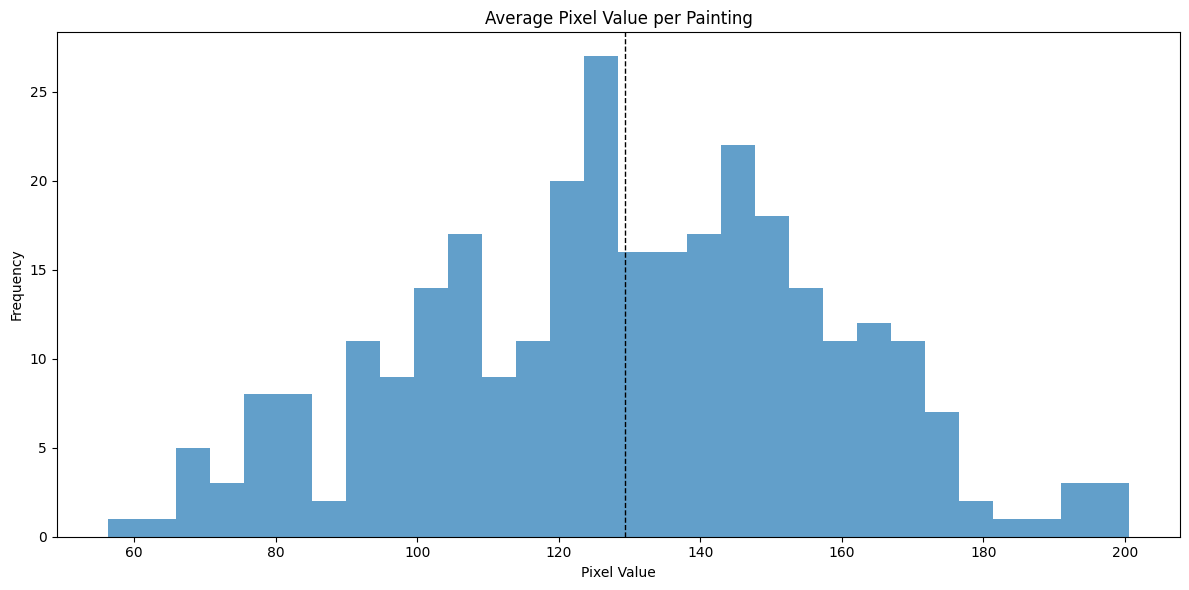

In [6]:
# Calculate the mean pixel value per observation (darkness)
mean_darkness = np.mean(paintings, axis=(1, 2, 3))
overall_average_darkness = np.mean(mean_darkness, axis=0)

# Plot a histogram of mean pixel value per observation
plt.figure(figsize=(12, 6))

plt.hist(mean_darkness, bins=30, alpha=0.7)
plt.axvline(overall_average_darkness, color='k', linestyle='dashed', linewidth=1)
plt.title('Average Pixel Value per Painting')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Photo shape: (256, 256, 3)


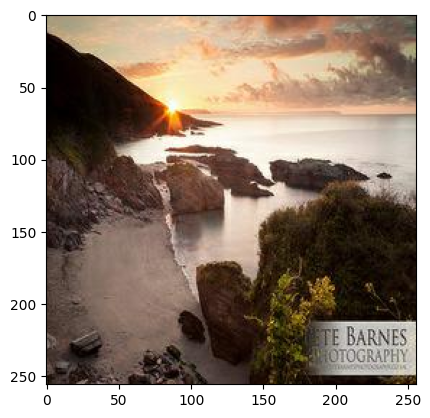

In [7]:
# Load and display and example photo
photo_paths = ['\\'.join(['photo_jpg', f]) for f in os.listdir('photo_jpg')]
example_photo_path = choice(photo_paths)
example_photo = Image.open(example_photo_path)
example_photo_array = np.array(example_photo)

print(f'Photo shape: {example_photo_array.shape}')
plt.imshow(example_photo)
plt.show()

In [8]:
photos = None
photos = np.empty((7038, 256, 256, 3))
for i, path in enumerate(photo_paths):
    photo = Image.open(path)
    photos[i] = np.array(photo)

# Data Cleaning
There are no missing values in the dataset so no imputation is necessary. All of the data is in image form with numerical values for the individual pixels. This means there is no need to encode categorical data. I will normalize the painting's pixel values to [0,1] range using the rescale parameter in ImageDataGenerator. I will take this data cleaning step because different scales can easily be amplified through a neural network and have an outsized effect on the model. 

The main thing of note from EDA is that there are only 300 Monet paintings with which to train the model. This is not enough data to train a model that needs to learn the style well enough to convert 7,000-10,000 photos. I will need to use data augmentation to increase the effective painting dataset size. I need to use a generator because the datasets are too large to load onto my GPU in full. Therefore, I will use augmentation as part of ImageDataGenerator so the model will see a slightly different version of the image each time, improving generalization.

In [20]:
datagen = ImageDataGenerator(
    rescale = 1/255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='reflect'
)

# Plan of Analysis
CycleGAN is the perfect architecture for this project. CycleGAN is specifically designed to transfer styles to images without a one-to-one mapping between source and target domains[5]. This makes CycleGAN preferable to other GAN architectures like Conditional GAN which requires labels. For this project the model will convert real images to the style of Monet then back to real image. The model will also convert Monet paintings to real images then back to paintings. For both cycles I will apply a discriminator to identify real or generated images. The loss functions for the two reconstruction cycles and discriminators will be combined to guide the training of the generators and discriminators. 

I will use the generator and discriminator classes from pix2pix.


# Model Building and Training

In [17]:
# Check that tensorflow is recognizing my GPU
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [21]:
# Create dataset of Monet paintings
monet_generator = datagen.flow(paintings, batch_size=32, shuffle=True)

# Create dataset of photos
photo_generator = datagen.flow(photos, batch_size=32, shuffle=True)

In [22]:
# Use generator and discriminator used in pix2pix
OUTPUT_CHANNELS = 3

# photo -> monet
generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
# monet -> photo
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
# compares generated monet with real monet
discriminator_m = pix2pix.discriminator(norm_type='instancenorm', target=False)
# compares generated photo with real photo
discriminator_p = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [23]:
# LOSS FUNCTIONS
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

# real_image is passed through generator to generate y_hat
# y_hat is passed through generator to generate cycled_image
LAMBDA = 10
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

# If a monet is pased through generator_g it should not modify the image since it already matches style of monet
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [24]:
# Define optimizers for generators and discriminators
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_p_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_m_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [25]:
# Define a training step
@tf.function
def train_step(real_p, real_m):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates photo -> monet
    # Generator F translates monet -> photo

    fake_m = generator_g(real_p, training=True)
    cycled_p = generator_f(fake_m, training=True)

    fake_p = generator_f(real_m, training=True)
    cycled_m = generator_g(fake_p, training=True)

    # same_x and same_y are used for identity loss.
    same_p = generator_f(real_p, training=True)
    same_m = generator_g(real_m, training=True)

    disc_real_p = discriminator_p(real_p, training=True)
    disc_real_m = discriminator_m(real_m, training=True)

    disc_fake_p = discriminator_p(fake_p, training=True)
    disc_fake_m = discriminator_m(fake_m, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_m)
    gen_f_loss = generator_loss(disc_fake_p)

    total_cycle_loss = calc_cycle_loss(real_p, cycled_p) + calc_cycle_loss(real_m, cycled_m)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_m, same_m)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_p, same_p)

    disc_p_loss = discriminator_loss(disc_real_p, disc_fake_p)
    disc_m_loss = discriminator_loss(disc_real_m, disc_fake_m)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_p_gradients = tape.gradient(disc_p_loss, 
                                            discriminator_p.trainable_variables)
  discriminator_m_gradients = tape.gradient(disc_m_loss, 
                                            discriminator_m.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_p_optimizer.apply_gradients(zip(discriminator_p_gradients,
                                                discriminator_p.trainable_variables))

  discriminator_m_optimizer.apply_gradients(zip(discriminator_m_gradients,
                                                discriminator_m.trainable_variables))

In [26]:
EPOCHS = 50

for epoch in range(EPOCHS):
  for _ in range(len(monet_generator)):
    real_monet, _ = next(monet_generator)
    real_photo, _ = next(photo_generator)

    train_step(real_photo, real_monet)

NameError: name 'scipy' is not defined

# Results and Analysis

# Conclusion and Discussion

## Citations
[1] https://blog.keras.io/building-autoencoders-in-keras.html

[2] https://www.kaggle.com/competitions/gan-getting-started

[3] https://www.metmuseum.org/toah/hd/cmon/hd_cmon.htm

[4] https://jonathan-hui.medium.com/gan-cyclegan-6a50e7600d7

[5] https://www.tensorflow.org/tutorials/generative/cyclegan